In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

# Attribute Information:

**Input variables**:

`bank client data`:

1.  age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

`related with the last contact of the current campaign`:

8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

`other attributes`:

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

`social and economic context attributes`

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# Предобработка данных 

In [2]:
data = pd.read_csv('../data/raw/bank-additional.csv', delimiter=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


Проверим, есть ли пропуски в данных

In [3]:
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Выделим категориальные признаки и закодируем их:

In [4]:
categorical_feature_mask = (data.dtypes == object)
categorical_cols = data.columns[categorical_feature_mask].tolist()

In [5]:
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [6]:
le = LabelEncoder()
data[categorical_cols] = data[categorical_cols].apply(lambda col: le.fit_transform(col))
data[categorical_cols].head(10)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,1,1,2,0,2,0,0,6,0,1,0
1,7,2,3,0,0,0,1,6,0,1,0
2,7,1,3,0,2,0,1,4,4,1,0
3,7,1,2,0,1,1,1,4,0,1,0
4,0,1,6,0,2,0,0,7,1,1,0
5,7,2,6,0,0,0,0,9,2,0,0
6,0,2,6,0,2,0,0,9,1,1,0
7,2,1,6,1,2,0,0,7,1,1,0
8,7,0,5,0,0,0,0,7,3,0,0
9,1,1,2,1,0,0,1,6,2,1,0


Выделим числовые признаки, посмотрим на их распределение и отмасштабируем:

In [8]:
numerical_cols = list(set(data.columns).difference(set(categorical_cols)))

In [9]:
numerical_cols

['pdays',
 'age',
 'euribor3m',
 'cons.conf.idx',
 'nr.employed',
 'previous',
 'duration',
 'cons.price.idx',
 'campaign',
 'emp.var.rate']

Удалим признак duration, поскольку он не может быть получен, до такого как известен ответ (attribute information):

In [10]:
del data['duration']

In [11]:
numerical_cols.remove('duration')

Для численных признаков построим boxplot, чтобы оценить количество выбросов:

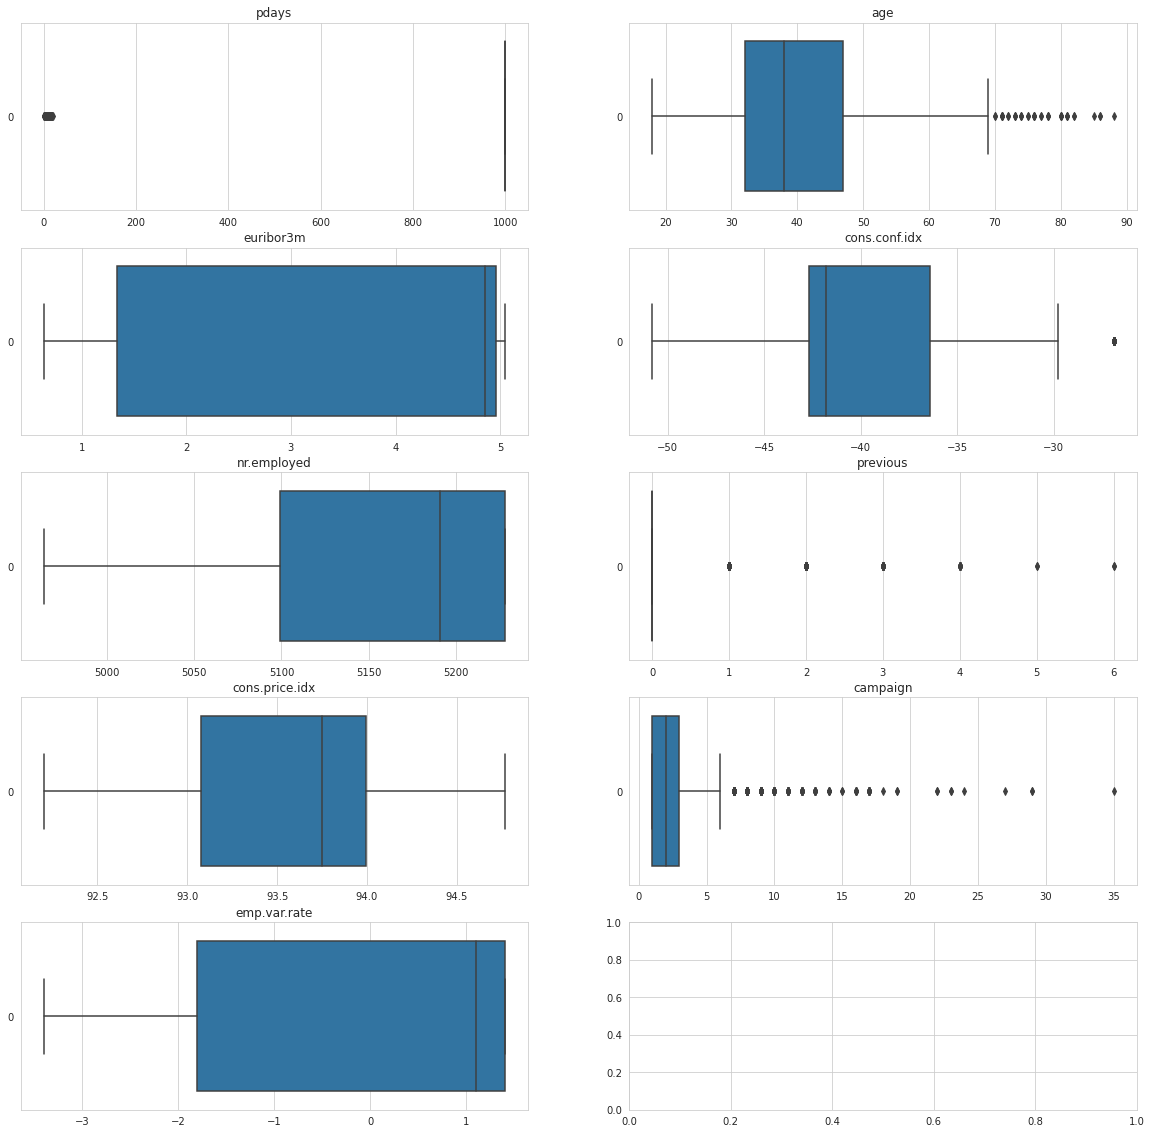

In [13]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"), sns.color_palette('tab10'):
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
    for i, param in enumerate(numerical_cols):
        sns.boxplot(data=data[param], orient='h', ax=ax[i // 2, i %2])
        ax[i // 2, i %2].set_title(param)    

НЕ будем масштабировать признак "pdays", поскольку он содержит очень большие значения (999), в случае, если с клиентом не контактировали, которые сильно повлияют на среднее и дисперсию. 

In [14]:
scaler = StandardScaler()
numerical_cols.remove('pdays')
data[numerical_cols] = data[numerical_cols].apply(lambda col: 
                                                  scaler.fit_transform(
                                                      col.to_numpy().reshape(-1, 1)
                                                  ).ravel()
                                                 )

In [15]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,-0.980752,1,1,2,0,2,0,0,6,0,-0.209228,999,-0.351356,1,-1.206054,-1.185448,-1.240939,-1.331707,-0.914779,0
1,-0.107991,7,2,3,0,0,0,1,6,0,0.569634,999,-0.351356,1,0.649441,0.715193,0.892269,0.711698,0.332862,0
2,-1.465619,7,1,3,0,2,0,1,4,4,-0.598660,999,-0.351356,1,0.841389,1.528273,-0.283172,0.773427,0.836535,0
3,-0.204965,7,1,2,0,1,1,1,4,0,0.180203,999,-0.351356,1,0.841389,1.528273,-0.283172,0.771697,0.836535,0
4,0.667795,0,1,6,0,2,0,0,7,1,-0.598660,999,-0.351356,1,-0.118350,-0.655478,-0.326707,0.328632,0.398028,0


Сохраним данные для дальнейшего использования

In [17]:
data.to_csv('../data/processed/bank-additional-encoded-and-scaled.csv', sep=';')